##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Dogs vs Cats Image Classification With Image Augmentation

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l05c02_dogs_vs_cats_with_augmentation.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

このチュートリアルでは、画像を猫の写真または犬の写真に分類する方法について説明します。 `tf.keras.Sequential`モデルを使用して画像分類子を構築し、` tf.keras.preprocessing.image.ImageDataGenerator`を使用してデータをロードします。

## Specific concepts that will be covered:
その過程で、以下の概念に関する実践的な経験を構築し、直感を開発します。

* `tf.keras.preprocessing.image.ImageDataGenerator`クラスを使用して_データ入力パイプラインを構築—ディスク上のデータを効率的に操作してモデルとインターフェイスする方法
* _Overfitting_-それは何ですか、どのように識別し、どのように防ぐことができますか？
* _Data Augmentation_および_Dropout_-データパイプラインおよび画像分類子モデルに組み込むコンピュータービジョンタスクの過剰適合と戦うための重要な手法。

## We will follow the general machine learning workflow:

1. データを調べて理解する
2. 入力パイプラインを構築する
3. モデルを作成する
4. モデルのトレーニング
5. モデルをテストする
6. モデルの改善/プロセスの繰り返し

**Before you begin**

このノートブックでコードを実行する前に、上記のメニューで**Runtime-> Reset all runtimes**に移動してランタイムをリセットします。 複数のノートブックを使用している場合、これはColabのメモリ制限に到達することを回避するのに役立ちます。


# Importing packages

Let's start by importing required packages:

*   os — to read files and directory structure
*   numpy — for some matrix math outside of TensorFlow
*   matplotlib.pyplot — to plot the graph and display images in our training and validation data

In [1]:
#from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
# try:
#   # Use the %tensorflow_version magic if in colab.
#   %tensorflow_version 2.x
# except Exception:
#   pass

import tensorflow as tf

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

画像分類子を作成するには、まずデータセットをダウンロードします。 使用しているデータセットは、<a href="https://www.kaggle.com/c/dogs-vs-cats/data" target="_blank">犬と猫</a>のデータセットのフィルタリングされたバージョンです Kaggleから（最終的に、このデータセットはMicrosoft Researchによって提供されます）。

以前のColabsでは、<a href="https://www.tensorflow.org/datasets" target="_blank"> TensorFlow Datasets </a>を使用しました。これは、データセットを使用する非常に簡単で便利な方法です。 ただし、このColabでは、ディスクからデータを読み取るクラス `tf.keras.preprocessing.image.ImageDataGenerator`を使用します。 したがって、URLから*Dogs vs. Cats*を直接ダウンロードし、Colabファイルシステムに解凍する必要があります。

In [5]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)

ダウンロードしたデータセットのディレクトリ構造は次のとおりです。

<pre style="font-size: 10.0pt; font-family: Arial; line-height: 2; letter-spacing: 1.0pt;" >
<b>cats_and_dogs_filtered</b>
|__ <b>train</b>
    |______ <b>cats</b>: [cat.0.jpg, cat.1.jpg, cat.2.jpg ...]
    |______ <b>dogs</b>: [dog.0.jpg, dog.1.jpg, dog.2.jpg ...]
|__ <b>validation</b>
    |______ <b>cats</b>: [cat.2000.jpg, cat.2001.jpg, cat.2002.jpg ...]
    |______ <b>dogs</b>: [dog.2000.jpg, dog.2001.jpg, dog.2002.jpg ...]
</pre>

次の端末コマンドでディレクトリを一覧表示できます。

In [6]:
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

In [7]:
train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures

### Understanding our data

トレーニングと検証のディレクトリにある猫と犬の画像の数を見てみましょう

In [8]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [9]:
print('total training cat images:', num_cats_tr)
print('total training dog images:', num_dogs_tr)

print('total validation cat images:', num_cats_val)
print('total validation dog images:', num_dogs_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


# Setting Model Parameters

便宜上、データセットの前処理とネットワークのトレーニング中に後で使用される変数を設定します。

In [10]:
BATCH_SIZE = 100
IMG_SHAPE  = 150 # Our training data consists of images with width of 150 pixels and height of 150 pixels

トレーニングおよび検証イメージ用のジェネレーターを定義した後、**flow_from_directory**メソッドはディスクからイメージをロードし、再スケーリングを適用し、1行のコードを使用して必要な次元にサイズ変更します。

# Data Augmentation

オーバーフィッティングは、少数のトレーニングサンプルがある場合によく発生します。この問題を解決する1つの方法は、十分な数と種類のトレーニング例が含まれるようにデータセットを拡張することです。データ増強は、信じられそうな画像を生成するランダム変換によりサンプルを増強することにより、既存の訓練サンプルからより多くの訓練データを生成するアプローチを取ります。目標は、トレーニング時に、モデルがまったく同じ画像を2回表示しないことです。これにより、モデルはデータのより多くの側面にさらされ、より一般化できるようになります。

**tf.keras**では、前に使用したのと同じ**ImageDataGenerator**クラスを使用してこれを実装できます。引数の形式としてデータセットに必要なさまざまな変換を渡すだけで、トレーニングプロセス中にデータセットへの適用を処理します。

まず、画像を表示できる関数を定義して、実行された拡張の種類を確認しましょう。次に、トレーニング中に使用する特定の拡張機能について説明します。


In [11]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

### Flipping the image horizontally

データセットに水平反転増強をランダムに適用し、個々の画像が変換後にどのように見えるかを確認することから始めます。 これは、引数として「horizontal_flip = True」を「ImageDataGenerator」クラスに渡すことで実現されます。

In [12]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE,IMG_SHAPE))

Found 2000 images belonging to 2 classes.


変換の動作を確認するには、トレーニングセットから1つのサンプル画像を取得して、5回繰り返します。 拡張は、各繰り返しにランダムに適用されます（または適用されません）。

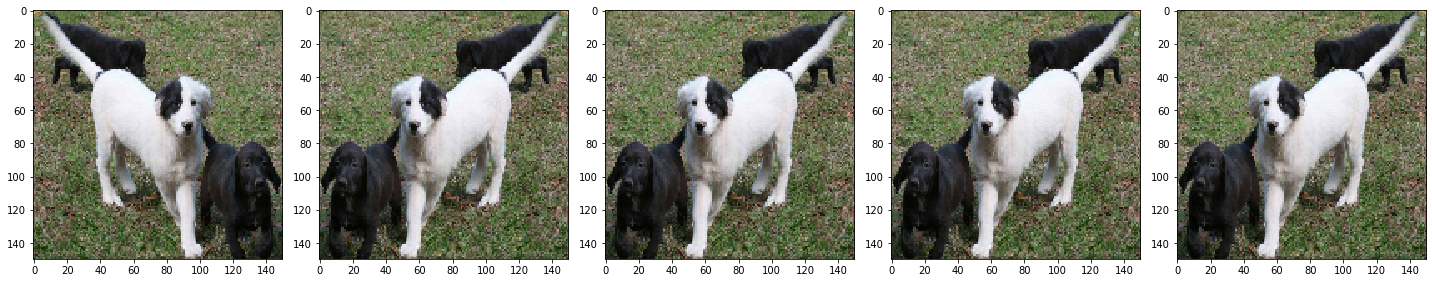

In [13]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Rotating the image

The rotation augmentation will randomly rotate the image up to a specified number of degrees. Here, we'll set it to 45.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))

To see the transformation in action, let's once again take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Applying Zoom

We can also apply Zoom augmentation to our dataset, zooming images up to 50% randomly.

In [ ]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                               directory=train_dir,
                                               shuffle=True,
                                               target_size=(IMG_SHAPE, IMG_SHAPE))


One more time, take a sample image from our training set and repeat it. The augmentation will be randomly applied (or not) to each repetition.

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Putting it all together

We can apply all these augmentations, and even others, with just one line of code, by passing the augmentations as arguments with proper values.

Here, we have applied rescale, rotation of 45 degrees, width shift, height shift, horizontal flip, and zoom augmentation to our training images.

In [ ]:
image_gen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(IMG_SHAPE,IMG_SHAPE),
                                                     class_mode='binary')

Let's visualize how a single image would look like five different times, when we pass these augmentations randomly to our dataset. 

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

### Creating Validation Data generator

Generally, we only apply data augmentation to our training examples, since the original images should be representative of what our model needs to manage. So, in this case we are only rescaling our validation images and converting them into batches using ImageDataGenerator.

In [ ]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE,
                                                 directory=validation_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='binary')

# Model Creation

## Define the model

The model consists of four convolution blocks with a max pool layer in each of them.

Before the final Dense layers, we're also applying a Dropout probability of 0.5. It means that 50% of the values coming into the Dropout layer will be set to zero. This helps to prevent overfitting.

Then we have a fully connected layer with 512 units, with a `relu` activation function. The model will output class probabilities for two classes — dogs and cats — using `softmax`. 

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

### Compiling the model

As usual, we will use the `adam` optimizer. Since we output a softmax categorization, we'll use `sparse_categorical_crossentropy` as the loss function. We would also like to look at training and validation accuracy on each epoch as we train our network, so we are passing in the metrics argument.

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Model Summary

Let's look at all the layers of our network using **summary** method.

In [ ]:
model.summary()

### Train the model

It's time we train our network.

Since our batches are coming from a generator (`ImageDataGenerator`), we'll use `fit_generator` instead of `fit`.

In [ ]:
epochs=100
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

### Visualizing results of the training

We'll now visualize the results we get after training our network.

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()